In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyproj import Transformer

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression

from sklearn.cluster import KMeans

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [93]:
#기본 정보
coord_std=pd.read_excel('./기본정보_위경도.xlsx')

#숙박 유형
pension=pd.read_excel("./숙박유형_관광펜션업.xlsx")
camping=pd.read_excel("./숙박유형_일반야영장업.xlsx")
hanok=pd.read_excel("./숙박유형_한옥체험업.xlsx")
resort=pd.read_excel("./숙박유형_호텔리조트.xlsx") 

#비대면
alien1=pd.read_csv('./비대면_외지인방문자수_1.csv',encoding='cp949')
alien2=pd.read_csv('./비대면_외지인방문자수_2.csv',encoding='cp949')
resider1=pd.read_csv('./비대면_현지인방문자수_1.csv',encoding='cp949')
resider2=pd.read_csv('./비대면_현지인방문자수_2.csv',encoding='cp949')

#식음및부대시설
meal=pd.read_csv('./부대시설_음식점.csv',encoding='cp949')
cafe=pd.read_csv('./부대시설_휴게음식점.csv',encoding='utf-8')

#콘텐츠
contents1=pd.read_csv('./콘텐츠_관광지_검색순위_상.csv',encoding='cp949')
contents2=pd.read_csv('./콘텐츠_관광지_검색순위_하.csv',encoding='cp949')

In [94]:
#xy좌표를 위경도로 변환
transformer = Transformer.from_crs(2097, 4326)

def convert_coordinates(lon, lat):
    new_lat, new_lon = transformer.transform(lat, lon) 
    return new_lon, new_lat

# 데이터 준비

숙소

In [95]:
#숙소
def accomm_preprocess(accomm):
    accomm.drop(accomm[(accomm['영업상태구분코드']!=1)].index,inplace=True)
    accomm=accomm[accomm['개방자치단체코드'].between(4800000,5010000)]
    accomm=accomm.loc[:,['개방자치단체코드','좌표정보(X)','좌표정보(Y)']]
    accomm.dropna(axis=0,inplace=True)
    return accomm

pension=accomm_preprocess(pension)
camping=accomm_preprocess(camping)
hanok=accomm_preprocess(hanok)
resort=accomm_preprocess(resort)

In [96]:
pension['경도'], pension['위도'] = zip(*pension.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))
camping['경도'], camping['위도'] = zip(*camping.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))
hanok['경도'], hanok['위도'] = zip(*hanok.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))
resort['경도'], resort['위도'] = zip(*resort.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))

In [97]:
accomm_df=pd.concat([pension,camping,hanok,resort],ignore_index=True)
accomm_df.drop(['좌표정보(X)','좌표정보(Y)'],axis=1,inplace=True)

In [98]:
acco_n=list(accomm_df['개방자치단체코드'].value_counts()) #지역별 숙소 개수

부대시설(카페)

In [99]:
#카페
def cafe_preprocess(cafe):
    cafe.drop(cafe[(cafe['영업상태명']!='영업/정상')].index,inplace=True)
    cafe=cafe.loc[:,['소재지전체주소','좌표정보(X)','좌표정보(Y)']]
    cafe.dropna(axis=0,inplace=True)
    return cafe

cafe=cafe_preprocess(cafe)
cafe['경도'], cafe['위도'] = zip(*cafe.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1))

In [100]:
cafe_address=cafe['소재지전체주소']
cafe_address_fr=cafe_address.str.slice(start=4, stop=9, step=1)
cafe_n=list(cafe_address_fr.value_counts())

매력 요소: 비대면 지수, 외부 유입 지수

In [101]:
alien=pd.concat([alien1,alien2],axis=1,ignore_index=True)
alien.drop([2],axis=1,inplace=True) #순위 제거
alien['외지인방문자_평균']=(alien[1]+alien[3])/2
alien['외지인방문자_변화량']=alien[3]-alien[1]


resider=pd.concat([resider1,resider2],axis=1,ignore_index=True)
resider.drop([2],axis=1,inplace=True)
resider['현지인방문자_평균']=(resider[1]+resider[3])/2
resider['현지인방문자_변화량']=resider[3]-resider[1]

attract_index=alien.index
ref_score=(alien['외지인방문자_평균']/resider['현지인방문자_평균'])*100 #선행연구 

attract_df=pd.concat([alien[0],alien['외지인방문자_평균'],alien['외지인방문자_변화량'],
                      resider['현지인방문자_평균'],resider['현지인방문자_변화량'],
                      ref_score],axis=1)
attract_col=['지역','외지인_평균','외지인_변화량','현지인_평균','현지인_변화량','비대면지수']
attract_df.columns=attract_col

In [102]:
attract_df['숙소개수']=acco_n
attract_df['카페개수']=cafe_n
print(attract_df) #1차 데이터 프레임 생성

     지역      외지인_평균    외지인_변화량      현지인_평균    현지인_변화량       비대면지수  숙소개수  카페개수
0   목포시  25342577.5  1375735.0  61463293.0  4834018.0   41.232053   268  1226
1   여수시  27043371.0   860290.0  54737364.5  4424665.0   49.405687   143  1179
2   순천시  25939672.5  2755781.0  60239103.5  4817389.0   43.061186    70   860
3   나주시  16335163.0    37614.0  26343338.0  1961084.0   62.008706    52   563
4   광양시  13620096.0   583696.0  27746306.0  2652488.0   49.087961    44   416
5   담양군  15548173.0   580902.0   9472426.5   965485.0  164.141395    43   366
6   곡성군   5699939.0   456798.0   5125011.5   247975.0  111.218072    39   264
7   구례군   5957218.5   465727.0   5052521.5   505985.0  117.905852    37   261
8   고흥군   6804036.5   -21535.0   9776511.5  1026949.0   69.595750    28   260
9   보성군   7103425.0   468294.0   7201938.0   680620.0   98.632132    27   193
10  화순군  12512281.5   545023.0  14853480.0   853464.0   84.238047    27   167
11  장흥군   5282706.0   319140.0   9099501.5   684541.0   58.05489

콘텐츠

In [103]:
contents2.drop('광역시/도',axis=1,inplace=True)

451
['순천만국가정원', '목포역', '순천역', '죽녹원', '오동도', '여수해상케이블카놀아정류장', 'LF스퀘어광양점', '완도항여객선터미널', '향일암', '목포해상케이블카북항승강장', '아쿠아플라넷여수', '여수엑스포역', '목포종합버스터미널', '화엄사', '나주역', '여수예술랜드', '목포연안여객선터미널', '녹동항', '롯데아울렛남악점', '백양사', '여수공항', '메타프로방스', '순천종합버스터미널', '순천만습지', '낙안읍성민속마을', '섬진강기차마을', '유월드루지테마파크', '율포해수욕장', '영광종합버스터미널', '선암사', '아르떼뮤지엄여수', '불갑사', '송광사', '진도항', '녹동신항연안여객선터미널', 'NC백화점순천점', '여수수산시장', '돌산공원', '무안CC', 'CGV순천신대', '장성역', '푸른솔GC', '무안국제공항', '호남해안로드4코스영광백수해안도로', '여수수산물특화시장', '대흥사', '벌교역', '목포항국제여객터미널', '골드레이크CC', '해남종합버스터미널', '담양관방제림', '사성암', '여수종합버스터미널', '여천역', '암태남강선착장', '중마버스터미널', '신지명사십리해수욕장', '무등산CC', '만성리검은모래해변', '메타세쿼이아가로수길', '구례구역', '순천아랫장', '운림산방', '순천오픈세트장', '아크로CC', '여수연안여객선터미널', '정남진장흥토요시장', '강진버스여객터미널', '신기항여객터미널', 'JNJ골프리조트', '소쇄원', '갓바위', '함평엘리체CC', '나로우주센터우주과학관', '천은사', '진남관공사중(2023년12월완공예정)', '땅끝전망대', '골프존카운티순천', '돌머리해변', '무안시외버스터미널', '목포북항', '땅끝선착장', '여수구항방파제등대', '목포근대역사관1관', '청호시장', '다산베아채CC', '파인비치골프링크스', '목포종합수산시장', '화순CC', '웅천친수공원', '광주CC', '메타세콰이어길', '사우스링스영암CC짐앵', '파인힐

Text(0.5, 1.0, '전라남도 관광지 검색량')

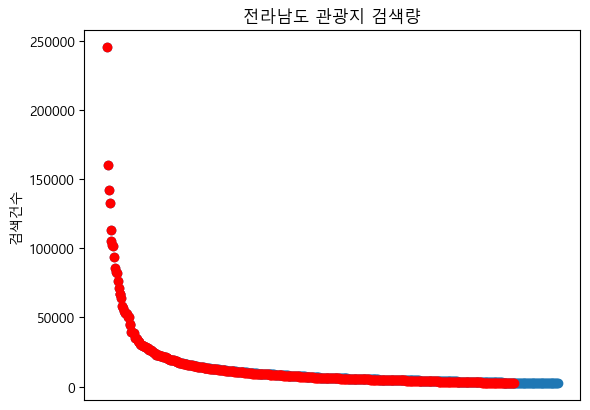

In [104]:
count_num=0
sites=[]
rnum=[]

for i in range(len(contents2)): #22'09~23'08
   for j in range(len(contents1)): #21'09~22'08
        if contents2['관광지명'][i]==contents1['관광지명'][j]:
            count_num+=1
            sites.append(contents2['관광지명'][i])
            rnum.append(contents2['검색건수'][i])

print(count_num) #451: 인기 관광지 500곳 중 451곳은 반복해서 수요가 많다.
print(sites) #사람들이 반복해서 찾는 곳

x1=np.arange(len(contents2))
plt.scatter(x1,contents2['검색건수'])
x2=np.arange(len(rnum))
plt.scatter(x2,rnum,c='r')

plt.xticks([])

plt.ylabel('검색건수')
plt.title('전라남도 관광지 검색량') #가는 곳(만) 또 감

In [105]:
ct2=contents2.drop_duplicates(subset=['시/군/구'])
contents_df=ct2.drop(['중분류 카테고리','순위','관광지명','도로명주소'], axis=1).reset_index(drop=True)
print(contents_df)

   시/군/구     소분류 카테고리    검색건수
0    순천시         기타관광  245254
1    목포시         교통시설  159899
2    담양군         자연공원  132973
3    여수시  자연경관(하천/해양)  113284
4    광양시          쇼핑몰  102492
5    완도군         교통시설  101505
6    구례군         종교성지   71502
7    나주시         교통시설   66728
8    고흥군  자연경관(하천/해양)   58260
9    무안군          쇼핑몰   57042
10   장성군         종교성지   54430
11   곡성군         기타관광   45263
12   보성군  자연경관(하천/해양)   39860
13   영광군         교통시설   39224
14   진도군  자연경관(하천/해양)   34692
15   해남군         종교성지   27724
16   신안군         교통시설   23194
17   화순군      육상레저스포츠   22783
18   영암군      육상레저스포츠   21308
19   장흥군           시장   20611
20   강진군         교통시설   20606
21   함평군      육상레저스포츠   19333


In [106]:
visit=[]
contents_keyword=[]

for i in range(len(meal)):
    for j in range(len(contents_df)):
        if meal['항목'][i]==contents_df['시/군/구'][j]:
            visit.append(contents_df['검색건수'][j])
            contents_keyword.append(contents_df['소분류 카테고리'][j])

meal['검색건수']=visit
meal['지역_키워드']=contents_keyword

In [107]:
meal_columns=['항목','음식점개수','경도','위도','검색건수','지역키워드']
meal.columns=meal_columns

In [108]:
meal['관광지']=[76,41,40,26,25,19,25,12,16,23,18,
                        23,21,16,18,13,17,18,14,16,11,12]
print(meal)

     항목  음식점개수          경도         위도    검색건수        지역키워드  관광지
0   여수시   3875  127.662222  34.760374  113284  자연경관(하천/해양)   76
1   순천시   3157  127.483333  34.950000  245254         기타관광   41
2   목포시   2977  126.350000  34.766667  159899         교통시설   40
3   광양시   1974  127.695501  34.940548  102492          쇼핑몰   26
4   나주시   1343  126.716667  35.033333   66728         교통시설   25
5   무안군   1016  126.481686  34.990454   57042          쇼핑몰   19
6   해남군    798  126.598927  34.573252   27724         종교성지   25
7   영암군    696  126.696792  34.800169   21308      육상레저스포츠   12
8   고흥군    689  127.284978  34.611222   58260  자연경관(하천/해양)   16
9   화순군    654  126.986480  35.064503   22783      육상레저스포츠   23
10  완도군    610  126.755054  34.311060  101505         교통시설   18
11  담양군    586  126.988167  35.321139  132973         자연공원   23
12  영광군    582  126.511987  35.277172   39224         교통시설   21
13  보성군    494  127.079894  34.771456   39860  자연경관(하천/해양)   16
14  장성군    476  126.784854  35.301833   

In [109]:
a_index=attract_df['지역']
m_index=meal['항목']

calmness=[]
accommodation=[]
cafeteria=[]

entranger_avg=[]
entranger_diff=[]
aborigene_avg=[]
aborigene_diff=[]


for i in range(len(meal)):
    for j in range(len(attract_df)):
        if m_index[i]==a_index[j]:
            calmness.append(attract_df['비대면지수'][j])
            accommodation.append(attract_df['숙소개수'][j])
            cafeteria.append(attract_df['카페개수'][j])
            aborigene_avg.append(attract_df['현지인_평균'][j])
            aborigene_diff.append(attract_df['현지인_변화량'][j])
            entranger_avg.append(attract_df['외지인_평균'][j])
            entranger_diff.append(attract_df['외지인_변화량'][j])
        else:
            continue


meal['비대면지수']=calmness
meal['숙소개수']=accommodation
meal['카페개수']=cafeteria

meal['현지인_평균']=aborigene_avg
meal['현지인_변화량']=aborigene_diff

meal['외지인_평균']=entranger_avg
meal['외지인_변화량']=entranger_diff

meal['음식점개수']=meal['음식점개수'].astype('int64')

# 특성 스케일링(표준화)

: 항목 마다 값이 크게 다르니 이상치에 영향 덜 받는 표준화로 특성 스케일링

In [110]:
ck=pd.get_dummies(contents_keyword,dtype='int64') #지역별 키워드를 원핫 인코딩

feat_df=pd.concat([meal,ck],axis=1,ignore_index=True)

#특성 스케일링용 데이터 프레임
feat_df.drop([2,3,5],axis=1,inplace=True) #경도, 위도,지역키워드, 최종점수 제거
feat_df=feat_df.set_index([0])

feat_df.columns=['음식점개수','검색건수','관광지','비대면지수',
                  '숙소개수','카페개수','현지인_평균','현지인_변화량',
                  '외지인_평균','외지인_변화량','교통시설','기타관광',
                  '쇼핑몰','시장','육상레저스포츠',
                  '자연경관(하천/해양)','자연공원','종교성지']

print(feat_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 여수시 to 함평군
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   음식점개수        22 non-null     int64  
 1   검색건수         22 non-null     int64  
 2   관광지          22 non-null     int64  
 3   비대면지수        22 non-null     float64
 4   숙소개수         22 non-null     int64  
 5   카페개수         22 non-null     int64  
 6   현지인_평균       22 non-null     float64
 7   현지인_변화량      22 non-null     float64
 8   외지인_평균       22 non-null     float64
 9   외지인_변화량      22 non-null     float64
 10  교통시설         22 non-null     int64  
 11  기타관광         22 non-null     int64  
 12  쇼핑몰          22 non-null     int64  
 13  시장           22 non-null     int64  
 14  육상레저스포츠      22 non-null     int64  
 15  자연경관(하천/해양)  22 non-null     int64  
 16  자연공원         22 non-null     int64  
 17  종교성지         22 non-null     int64  
dtypes: float64(5), int64(13)
memory usage: 3.3+ KB
None


In [111]:
scaler=StandardScaler()

f_df=pd.DataFrame((scaler.fit_transform(feat_df)),
                  columns=['음식점개수','검색건수','관광지','비대면지수',
                  '숙소개수','카페개수','현지인_평균','현지인_변화량',
                  '외지인_평균','외지인_변화량','교통시설','기타관광',
                  '쇼핑몰','시장','육상레저스포츠',
                  '자연경관(하천/해양)','자연공원','종교성지'])

<Axes: >

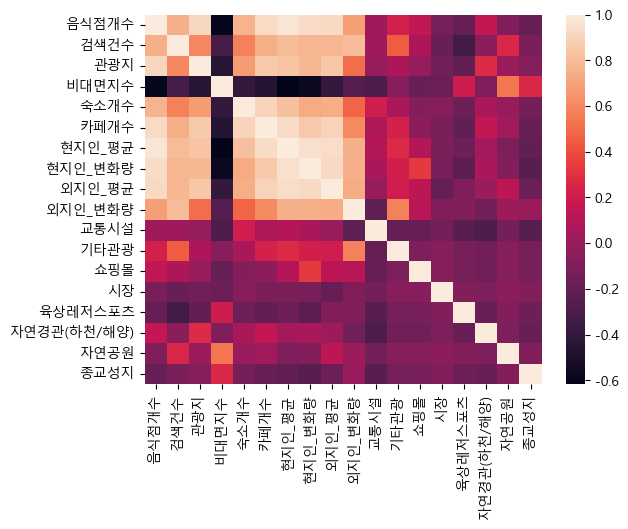

In [112]:
f_corr=f_df.corr()
sns.heatmap(f_corr)

#선행연구에서 제시한 '비대면지수'가 이질적으로 다른 요인과 대조됨.
#새로운 평가지표 개발 필요

In [131]:
#실제 평가된 지역의 워케이션 점수 추가
prof_score=[5,4,3,0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,2,0,0,0]
f_df['최종점수']=prof_score

lr_df=f_df.sort_values(by=['최종점수'],ascending=False).copy()

# 새 평가지표 개발

In [160]:
scored_x=lr_df.iloc[[0,1,2,3,4,5],:-1] #점수 공표된 지역들
tobe_x=lr_df.iloc[6:,:-1]

scored_y=lr_df.iloc[[0,1,2,3,4,5],-1:] #지역별 점수

scored_f=lr_df.iloc[[0,1,2,3,4,5],:]

Text(0, 0.5, '실제 점수')

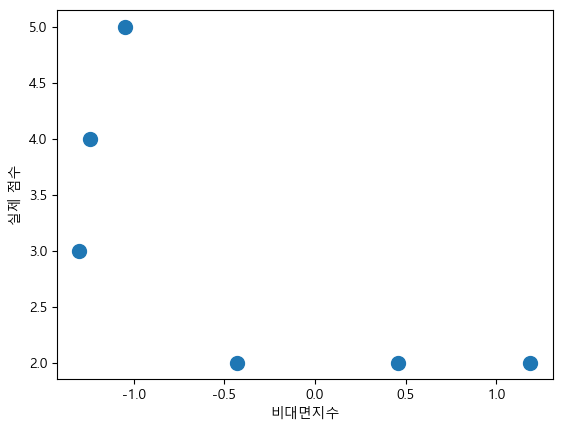

In [154]:
plt.scatter(scored_x['비대면지수'],scored_y,s=100)
plt.xlabel('비대면지수')
plt.ylabel('실제 점수')

#비대면지수가 낮을수록 높은 점수를 받음
#즉 워케이션에 비대면지수를 높게 부여한 선행연구 결과와 (또) 대조

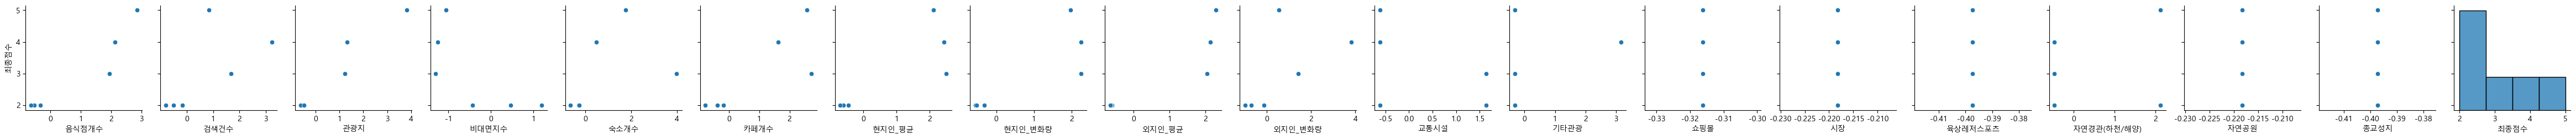

In [156]:
sns.pairplot(scored_f,y_vars=['최종점수'])

In [157]:
poly_features=PolynomialFeatures(degree=2,include_bias=False)

x_poly=poly_features.fit_transform(scored_x)

In [176]:
lr=LinearRegression()

lr.fit(scored_x,scored_y)
predict_y=lr.predict(tobe_x)

lr_df.iloc[6:,-1:]=predict_y

print(lr_df)

       음식점개수      검색건수       관광지     비대면지수      숙소개수      카페개수    현지인_평균  \
0   2.850863  0.836628  3.818339 -1.048810  1.755801  2.580347  2.122529   
1   2.132107  3.231442  1.309703 -1.242790  0.461714  1.623724  2.438057   
2   1.951917  1.682534  1.238028 -1.298716  3.971704  2.721291  2.508266   
13 -0.533698 -0.495772 -0.482179  0.456271 -0.300557 -0.376488 -0.603661   
18 -0.642813 -0.798205 -0.625530  1.187936 -0.655102 -0.772332 -0.692423   
8  -0.338493 -0.161874 -0.482179 -0.431506 -0.282830 -0.175567 -0.456008   
20 -0.713888 -0.397726 -0.840556  0.841082 -0.087830 -0.163572 -0.722775   
19 -0.651822 -0.589554 -0.482179  0.200875 -0.619647 -0.706358 -0.698742   
17 -0.608777  0.078424 -0.338829  1.045558 -0.123285 -0.172568 -0.726932   
16 -0.593761 -0.845168 -0.410504 -0.412144 -0.318284 -0.517432 -0.554437   
15 -0.583751 -0.845077 -0.697205 -0.784363 -0.300557 -0.493442 -0.494835   
14 -0.551717 -0.231376 -0.338829  1.255901 -0.548738 -0.667373 -0.540414   
11 -0.441601

In [181]:
corr_score=lr_df.corrwith(lr_df['최종점수'])
print(corr_score.sort_values(ascending=False))

최종점수           1.000000
관광지            0.957033
음식점개수          0.934554
외지인_평균         0.907142
현지인_평균         0.865225
카페개수           0.839874
현지인_변화량        0.839678
검색건수           0.685810
외지인_변화량        0.652331
숙소개수           0.592140
기타관광           0.238538
자연경관(하천/해양)    0.205544
쇼핑몰            0.107846
자연공원           0.033930
종교성지          -0.109324
교통시설          -0.131745
육상레저스포츠       -0.149801
시장            -0.183984
비대면지수         -0.402990
dtype: float64


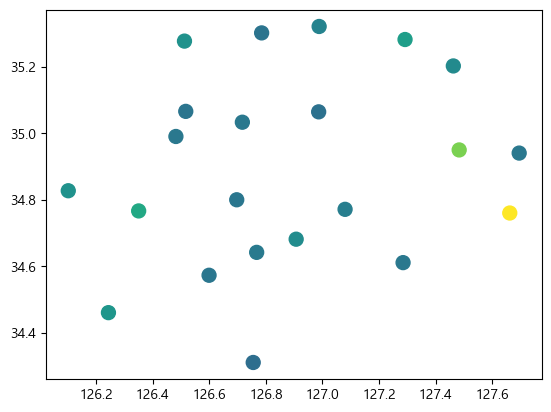

In [183]:
vmin = 0
vmax = 5

fig, ax = plt.subplots()

qcs = ax.scatter(
      meal['경도'],meal['위도'],
      c=lr_df['최종점수'],
      s=100,
      vmin=vmin, vmax=vmax
)

#plt.colorbar(label='점수')

plt.show()

# 주성분 분석
데이터의 개수가 매우 적다(22개)는 점 고려해 데이터셋을 대표하는 주성분 추출

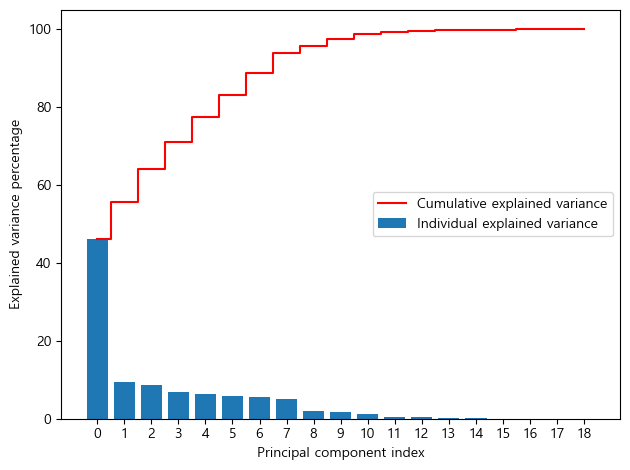

In [120]:
pca = PCA(n_components=None)
pca.fit(f_df)

exp_var = pca.explained_variance_ratio_ * 100 #해당 주성분으로 설명되는 분산 비율
cum_exp_var = np.cumsum(exp_var) #누적 (설명가능) 비율

plt.bar(range(0,19), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(0,19), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(0,19)))
plt.legend(loc=5)
plt.tight_layout()

In [121]:
#(누적)설명 정도가 약 90%에 이르는 7개 선택
pca=PCA(n_components=7)
x_pca=pca.fit_transform(f_df)

In [122]:
# plt.scatter(x_pca[:,0], x_pca[:,1], 
#                 s=100, alpha=0.5)

# plt.xlabel('주성분 1')
# plt.ylabel('주성분 2')
# plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

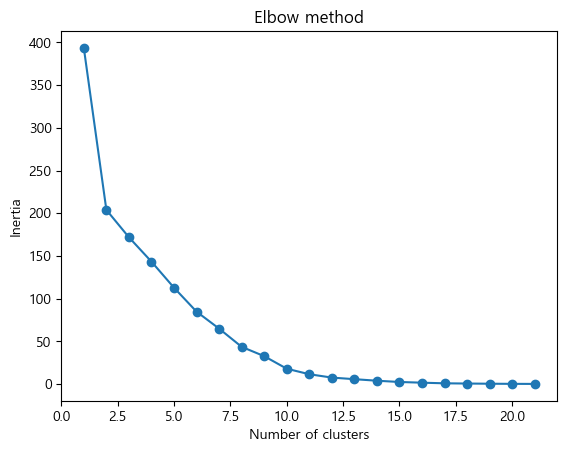

In [123]:
inertias = []

for i in range(1,22):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(x_pca)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,22), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


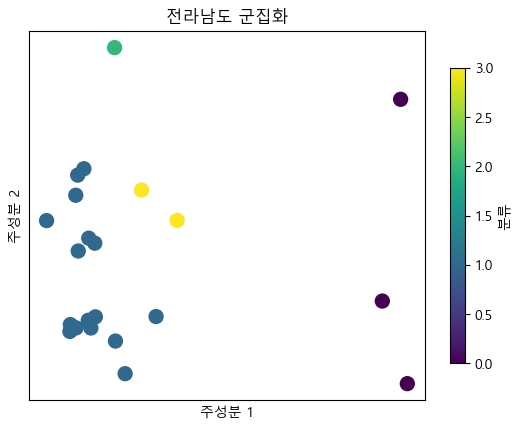

In [124]:
kmeans = KMeans(n_clusters=4,random_state=42)
kmeans.fit(x_pca)

x22=np.arange(len(f_df))
plt.scatter(x_pca[:,0],x_pca[:,1],c=kmeans.labels_,s=100)

plt.xticks([])
plt.xlabel('주성분 1')
plt.ylabel('주성분 2')
plt.yticks([])
plt.colorbar(shrink=0.8,label='분류')

plt.title('전라남도 군집화')
plt.show()

In [ ]:
#import mcpl

시각화

In [186]:
xmin=min(coord_std['경도'])
xmax=max(coord_std['경도'])
ymin=min(coord_std['위도'])
ymax=max(coord_std['위도'])

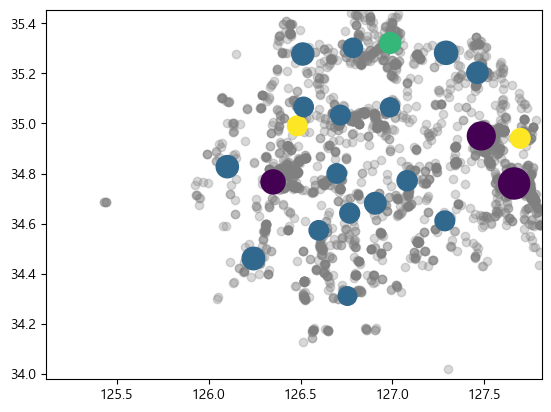

In [198]:
#숙소유형
plt.scatter(x=accomm_df['경도'],y=accomm_df['위도'],alpha=0.3,c='grey')

plt.scatter(x=cafe['경도'],y=cafe['위도'],alpha=0.3,c='gray')
plt.scatter(meal['경도'],meal['위도'],
            c=kmeans.labels_,s=lr_df['최종점수']*100)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.show() 

# MCLP